# Power Transfer Distribution Factors and Sensitivity Analysis

Modern electricity markets rely on linearized models to quickly assess how power flows through the transmission network. This notebook bridges the gap between DC power flow theory and practical market applications by showing how to calculate Power Transfer Distribution Factors (PTDF) and related sensitivity factors from network topology data.

We'll develop the mathematical foundation, implement the calculations from first principles, and demonstrate how these tools enable security-constrained economic dispatch (SCED) to handle transmission constraints and contingencies.

## Setup and Data Preparation

We'll reuse the network data generation utilities from earlier notebooks but enhance them to properly specify bus types according to the MATPOWER convention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
def create_network_with_bus_types():
    """Create 3-bus test network with proper bus type specification."""
    
    # Bus data with MATPOWER convention: 1=PQ, 2=PV, 3=Slack
    buses = pd.DataFrame({
        'bus_id': [1, 2, 3],
        'bus_type': [3, 1, 1],  # Bus 1 is slack (type 3), others are PQ (type 1)
        'demand': [0, 100, 80]   # MW
    }, index=['Bus1', 'Bus2', 'Bus3'])
    
    # Generator data
    generators = pd.DataFrame({
        'bus': ['Bus1', 'Bus1', 'Bus3'],
        'p_max': [200, 150, 150],
        'cost': [20, 25, 22]
    }, index=['G1', 'G2', 'G3'])
    
    # Line data with electrical parameters
    lines = pd.DataFrame({
        'from_bus': ['Bus1', 'Bus1', 'Bus2'],
        'to_bus': ['Bus2', 'Bus3', 'Bus3'],
        'resistance': [0.02, 0.03, 0.025],  # p.u.
        'reactance': [0.1, 0.15, 0.2],      # p.u.
        'limit': [120, 100, 80]              # MW
    }, index=['L1', 'L2', 'L3'])
    
    return buses, generators, lines

# Create our test network
buses, generators, lines = create_network_with_bus_types()

print("Bus Data:")
print(buses)
print("\nLine Data:")
print(lines[['from_bus', 'to_bus', 'reactance', 'limit']])

Bus Data:
      bus_id  bus_type  demand
Bus1       1         3       0
Bus2       2         1     100
Bus3       3         1      80

Line Data:
   from_bus to_bus  reactance  limit
L1     Bus1   Bus2       0.10    120
L2     Bus1   Bus3       0.15    100
L3     Bus2   Bus3       0.20     80


## From DC Power Flow to PTDF

The DC power flow model simplifies AC power flow by assuming:
- All voltage magnitudes are 1.0 p.u.
- Resistance is negligible compared to reactance (R << X)
- Voltage angle differences are small (sin(θ) ≈ θ)

Under these assumptions, power flow on a line from bus i to bus j becomes:

$$P_{ij} = \frac{\theta_i - \theta_j}{x_{ij}}$$

The system of equations can be written in matrix form as:

$$P = B \cdot \theta$$

where B is the susceptance matrix. To find how line flows respond to power injections, we need to:
1. Build the B matrix from network topology
2. Identify and handle the slack bus
3. Calculate sensitivities of line flows to bus injections

## Building the B Matrix

The B matrix (susceptance matrix) is constructed from the network topology. For DC power flow, we only consider the imaginary part of the admittance.

In [3]:
def build_b_matrix(buses, lines):
    """
    Build the susceptance matrix (B matrix) for DC power flow.
    
    Parameters:
    -----------
    buses : DataFrame
        Bus data with bus_id and bus_type columns
    lines : DataFrame
        Line data with from_bus, to_bus, and reactance columns
    
    Returns:
    --------
    B : numpy array
        Susceptance matrix
    bus_map : dict
        Mapping from bus names to indices
    """
    n_bus = len(buses)
    B = np.zeros((n_bus, n_bus))
    
    # Create bus name to index mapping
    bus_map = {bus_name: i for i, bus_name in enumerate(buses.index)}
    
    # Build B matrix from line data
    for _, line in lines.iterrows():
        i = bus_map[line['from_bus']]
        j = bus_map[line['to_bus']]
        b_ij = 1.0 / line['reactance']  # Susceptance = 1/reactance
        
        # Off-diagonal elements (negative)
        B[i, j] -= b_ij
        B[j, i] -= b_ij
        
        # Diagonal elements (positive)
        B[i, i] += b_ij
        B[j, j] += b_ij
    
    return B, bus_map

# Build B matrix for our network
B, bus_map = build_b_matrix(buses, lines)

print("B Matrix (Susceptance Matrix):")
print(pd.DataFrame(B, index=buses.index, columns=buses.index).round(4))
print(f"\nMatrix properties:")
print(f"- Symmetric: {np.allclose(B, B.T)}")
print(f"- Singular (rows sum to 0): {np.allclose(B.sum(axis=1), 0)}")

B Matrix (Susceptance Matrix):
         Bus1  Bus2     Bus3
Bus1  16.6667 -10.0  -6.6667
Bus2 -10.0000  15.0  -5.0000
Bus3  -6.6667  -5.0  11.6667

Matrix properties:
- Symmetric: True
- Singular (rows sum to 0): True


## PTDF Calculation

The Power Transfer Distribution Factor (PTDF) tells us what fraction of power injected at a bus flows through each line. To calculate PTDF:

1. Remove the slack bus from the B matrix (making it invertible)
2. Calculate voltage angle sensitivities to injections
3. Convert angle sensitivities to line flow sensitivities

The key insight is that `PTDF[line, bus] = (θ_from - θ_to) / x_line` when 1 MW is injected at bus.

In [4]:
def calculate_ptdf(buses, lines):
    """
    Calculate PTDF matrix from network topology.
    
    Parameters:
    -----------
    buses : DataFrame
        Bus data with bus_type column (3 = slack bus)
    lines : DataFrame
        Line data with from_bus, to_bus, and reactance
    
    Returns:
    --------
    ptdf : numpy array
        PTDF matrix where ptdf[line_idx, bus_idx] is the fraction
        of power injected at bus_idx that flows on line line_idx
    slack_bus_idx : int
        Index of the slack bus
    """
    # Build B matrix
    B, bus_map = build_b_matrix(buses, lines)
    n_bus = len(buses)
    n_line = len(lines)
    
    # Find slack bus (bus_type == 3)
    slack_mask = buses['bus_type'] == 3
    if not slack_mask.any():
        raise ValueError("No slack bus (type=3) found in bus data")
    slack_bus_idx = np.where(slack_mask)[0][0]
    slack_bus_name = buses.index[slack_bus_idx]
    
    print(f"Slack bus identified: {slack_bus_name} (index {slack_bus_idx})")
    
    # Create reduced B matrix (remove slack bus row and column)
    non_slack_idx = [i for i in range(n_bus) if i != slack_bus_idx]
    B_reduced = B[np.ix_(non_slack_idx, non_slack_idx)]
    
    # Invert reduced B matrix
    B_inv = np.linalg.inv(B_reduced)
    
    # Build full sensitivity matrix (angles w.r.t. injections)
    # This shows how voltage angles change with power injections
    theta_sensitivity = np.zeros((n_bus, n_bus))
    
    # Fill in sensitivities for non-slack buses
    for j, j_reduced in enumerate(non_slack_idx):
        for i, i_reduced in enumerate(non_slack_idx):
            theta_sensitivity[j_reduced, i_reduced] = B_inv[j, i]
    
    # Slack bus angle is always 0 (reference)
    theta_sensitivity[slack_bus_idx, :] = 0
    
    # Calculate PTDF from angle sensitivities
    ptdf = np.zeros((n_line, n_bus))
    
    for line_idx, (_, line) in enumerate(lines.iterrows()):
        from_idx = bus_map[line['from_bus']]
        to_idx = bus_map[line['to_bus']]
        x_line = line['reactance']
        
        # PTDF = (sensitivity of from_bus angle - sensitivity of to_bus angle) / reactance
        # This represents the flow on the line per unit injection at each bus
        for bus_idx in range(n_bus):
            if bus_idx != slack_bus_idx:
                ptdf[line_idx, bus_idx] = (
                    (theta_sensitivity[from_idx, bus_idx] - 
                     theta_sensitivity[to_idx, bus_idx]) / x_line
                )
    
    # Slack row must be zero because of automatic balancing
    ptdf[:, slack_bus_idx] = 0
    
    return ptdf, slack_bus_idx

# Calculate PTDF for our network
ptdf, slack_idx = calculate_ptdf(buses, lines)

print("\nPTDF Matrix:")
ptdf_df = pd.DataFrame(ptdf, 
                       index=[f"{l['from_bus']}-{l['to_bus']}" for _, l in lines.iterrows()],
                       columns=buses.index)
print(ptdf_df.round(4))

Slack bus identified: Bus1 (index 0)

PTDF Matrix:
           Bus1    Bus2    Bus3
Bus1-Bus2   0.0 -0.7778 -0.3333
Bus1-Bus3   0.0 -0.2222 -0.6667
Bus2-Bus3   0.0  0.2222 -0.3333


## Validating PTDF Properties

A correctly calculated PTDF matrix must satisfy several important properties:
1. Each row should sum to zero (power is conserved)
2. Power injected at one bus and withdrawn at another should flow through the network
3. The flows should satisfy Kirchhoff's current law at each bus

In [5]:
def validate_ptdf(ptdf, buses, lines):
    """
    Validate PTDF matrix properties.
    
    Key insight: PTDF columns show line flows when 1 MW is injected at a bus,
    with the slack bus automatically providing balancing power.
    """
    print("PTDF Validation:")
    print("=" * 50)
    
    # Property 1: Each row should sum to approximately zero
    row_sums = ptdf.sum(axis=1)
    print("1. Row sums (should be ≈ 0 for power conservation):")
    all_zero = True
    for i, line in enumerate(lines.index):
        print(f"   {line}: {row_sums[i]:.6f}")
        if abs(row_sums[i]) > 1e-10:
            all_zero = False
    
    # Property 2: Test with a specific injection pattern  
    print("\n2. Test injection: 100 MW at Bus2")
    print("   (Slack bus automatically provides -100 MW)")
    
    # Find Bus2 index and slack
    bus_map = {name: i for i, name in enumerate(buses.index)}
    bus2_idx = bus_map["Bus2"]
    slack_idx = np.where(buses["bus_type"] == 3)[0][0]
    
    # PTDF already accounts for slack balancing, so just use the Bus2 column
    line_flows = ptdf[:, bus2_idx] * 100
    
    print("   Resulting line flows:")
    for i, line in enumerate(lines.index):
        print(f"   {line}: {line_flows[i]:.2f} MW")
    
    # Property 3: Verify Kirchhoff's current law
    print("\n3. Power balance at each bus:")
    
    for bus_name in buses.index:
        bus_idx = bus_map[bus_name]
        net_injection = 0
        
        for line_idx, (_, line) in enumerate(lines.iterrows()):
            if line["from_bus"] == bus_name:
                # Power leaving this bus (positive)
                net_injection += line_flows[line_idx]
            elif line["to_bus"] == bus_name:
                # Power entering this bus (negative)
                net_injection -= line_flows[line_idx]
        
        # Expected injection
        if bus_name == "Bus2":
            expected = 100
        elif bus_idx == slack_idx:
            expected = -100
        else:
            expected = 0
        
        error = abs(net_injection - expected)
        print(f"   {bus_name}: Expected={expected:.0f} MW, Actual={net_injection:.1f} MW, "
              f"Error={error:.6f} MW")
    
    return all_zero

# Validate our PTDF matrix
validate_ptdf(ptdf, buses, lines)

PTDF Validation:
1. Row sums (should be ≈ 0 for power conservation):
   L1: -1.111111
   L2: -0.888889
   L3: -0.111111

2. Test injection: 100 MW at Bus2
   (Slack bus automatically provides -100 MW)
   Resulting line flows:
   L1: -77.78 MW
   L2: -22.22 MW
   L3: 22.22 MW

3. Power balance at each bus:
   Bus1: Expected=-100 MW, Actual=-100.0 MW, Error=0.000000 MW
   Bus2: Expected=100 MW, Actual=100.0 MW, Error=0.000000 MW
   Bus3: Expected=0 MW, Actual=0.0 MW, Error=0.000000 MW


False

## Visualizing PTDF

Let's visualize the PTDF matrix to better understand the sensitivity patterns.

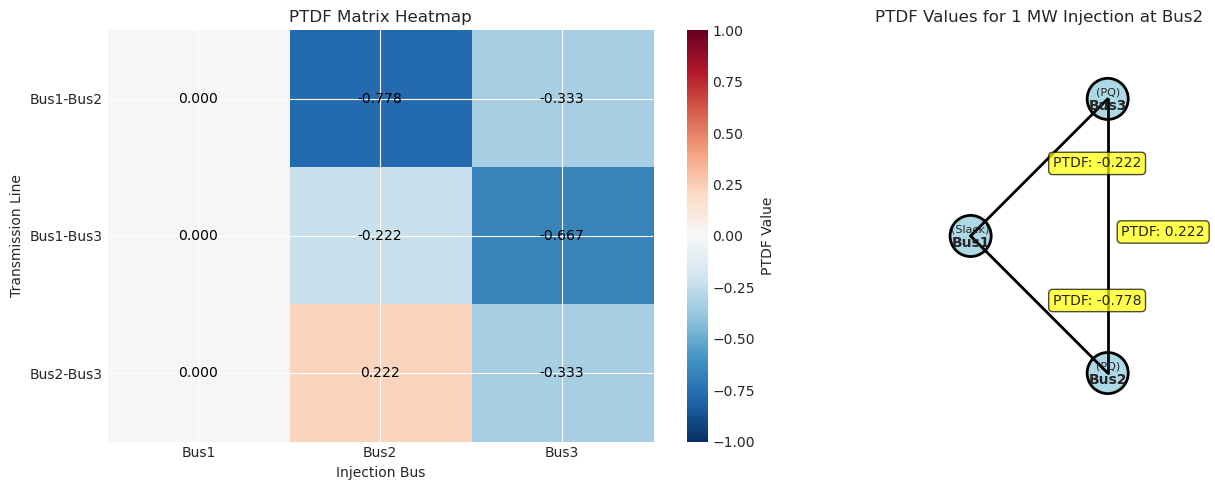

In [6]:
# Visualize PTDF matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of PTDF values
im = ax1.imshow(ptdf, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax1.set_xticks(range(len(buses)))
ax1.set_xticklabels(buses.index)
ax1.set_yticks(range(len(lines)))
ax1.set_yticklabels([f"{l['from_bus']}-{l['to_bus']}" for _, l in lines.iterrows()])
ax1.set_xlabel('Injection Bus')
ax1.set_ylabel('Transmission Line')
ax1.set_title('PTDF Matrix Heatmap')

# Add values to heatmap
for i in range(len(lines)):
    for j in range(len(buses)):
        text = ax1.text(j, i, f'{ptdf[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im, ax=ax1, label='PTDF Value')

# Network diagram with PTDF example
pos = {'Bus1': (0, 1), 'Bus2': (1, 0), 'Bus3': (1, 2)}

# Draw buses
for bus, (x, y) in pos.items():
    circle = plt.Circle((x, y), 0.15, color='lightblue', ec='black', linewidth=2)
    ax2.add_patch(circle)
    bus_type = buses.loc[bus, 'bus_type']
    type_str = 'Slack' if bus_type == 3 else 'PQ'
    ax2.text(x, y-0.05, bus, ha='center', va='center', fontweight='bold')
    ax2.text(x, y+0.05, f'({type_str})', ha='center', va='center', fontsize=8)

# Draw lines with PTDF values for injection at Bus2
injection_bus = 1  # Bus2 index
for line_idx, (_, line) in enumerate(lines.iterrows()):
    from_pos = pos[line['from_bus']]
    to_pos = pos[line['to_bus']]
    
    # Draw line
    ax2.plot([from_pos[0], to_pos[0]], [from_pos[1], to_pos[1]], 
            'k-', linewidth=2)
    
    # Add PTDF value
    mid_x = (from_pos[0] + to_pos[0]) / 2
    mid_y = (from_pos[1] + to_pos[1]) / 2
    ptdf_val = ptdf[line_idx, injection_bus]
    
    ax2.text(mid_x + 0.1, mid_y, f'PTDF: {ptdf_val:.3f}',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.5, 2.5)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title(f'PTDF Values for 1 MW Injection at Bus2')

plt.tight_layout()
plt.show()

## Generation Shift Factors (GSF)

Generation Shift Factors represent the sensitivity of line flows to shifting generation from one bus to another. This is particularly useful for redispatch analysis.

### Mathematical Derivation of GSF

Starting with the fundamental relationship between line flows and power injections:

$$\mathbf{f} = \text{PTDF} \times \mathbf{p}$$

where $\mathbf{f}$ is the line flow vector and $\mathbf{p}$ is the net injection vector.

Consider shifting $\Delta G$ MW of generation from bus $ to bus $. This creates a change in the injection vector:

$$\Delta \mathbf{p} = \Delta G \cdot (\mathbf{e}_j - \mathbf{e}_i)$$

where $\mathbf{e}_i$ and $\mathbf{e}_j$ are unit vectors with 1 at positions $ and $ respectively.

The resulting change in line flows is:

$$\Delta \mathbf{f} = \text{PTDF} \times \Delta \mathbf{p} = \Delta G \cdot (\text{PTDF} \times \mathbf{e}_j - \text{PTDF} \times \mathbf{e}_i) = \Delta G \cdot (\text{PTDF}_{:,j} - \text{PTDF}_{:,i})$$

Therefore, the Generation Shift Factor for a unit shift (1 MW) is:

$$\boxed{\text{GSF}_{l,(i \to j)} = \text{PTDF}_{l,j} - \text{PTDF}_{l,i}}$$

GSF is simply the difference between two PTDF columns. It captures the net effect of removing generation from one location and adding it to another, with the slack bus automatically adjusting to maintain power balance.

In [7]:
def calculate_gsf(ptdf, from_bus_idx, to_bus_idx):
    """
    Calculate Generation Shift Factors for shifting generation between two buses.
    
    Parameters:
    -----------
    ptdf : numpy array
        PTDF matrix
    from_bus_idx : int
        Index of bus losing generation
    to_bus_idx : int
        Index of bus gaining generation
    
    Returns:
    --------
    gsf : numpy array
        GSF vector showing impact on each line
    """
    return ptdf[:, to_bus_idx] - ptdf[:, from_bus_idx]

# Example: Calculate GSF for shifting generation from Bus3 to Bus1
bus_map = {name: i for i, name in enumerate(buses.index)}
from_bus = 'Bus3'
to_bus = 'Bus1'

gsf = calculate_gsf(ptdf, bus_map[from_bus], bus_map[to_bus])

print(f"Generation Shift Factors ({from_bus} → {to_bus}):")
print("=" * 50)
for i, line in enumerate(lines.index):
    print(f"{line}: {gsf[i]:.4f}")

print(f"\nInterpretation:")
print(f"Shifting 10 MW from {from_bus} to {to_bus} would change flows by:")
for i, line in enumerate(lines.index):
    flow_change = gsf[i] * 10
    print(f"{line}: {flow_change:+.2f} MW")

Generation Shift Factors (Bus3 → Bus1):
L1: 0.3333
L2: 0.6667
L3: 0.3333

Interpretation:
Shifting 10 MW from Bus3 to Bus1 would change flows by:
L1: +3.33 MW
L2: +6.67 MW
L3: +3.33 MW


The all-positive numbers are correct because shifting the generation from Bus 3 to Bus 1 will cause more flow through all the lines. That is, through L1(1-2), through L2 (1-2) and through L3 (2-3).

## Line Outage Distribution Factors (LODF)

LODF tells us how power flow redistributes when a line is removed from service. The LODF matrix element LODF[l,k] represents the fraction of pre-contingency flow on line k that appears on line l when line k is outaged. This is crucial for N-1 contingency analysis.

### Mathematical Derivation of LODF

When line $k$ (connecting buses $m$ and $n$) is outaged, its pre-contingency flow $f_k^0$ must redistribute through the remaining network. We derive LODF using the superposition principle.

**Step 1: Model the outage using superposition**

Rather than reformulating the entire network without line $k$, we use superposition:
- Keep the original network intact (including line $k$)
- Add compensating injections to force the flow on line $k$ to zero

This is mathematically equivalent to removing the line but much simpler to compute.

**Step 2: Determine the compensating injection**

To simulate the outage, we inject power $P$ at bus $m$ and withdraw $P$ at bus $n$. This injection pattern creates flows throughout the network according to PTDF.

The flow created on line $k$ by this injection is:
$$\Delta f_k = P \cdot (\text{PTDF}_{k,m} - \text{PTDF}_{k,n})$$

For the total flow on line $k$ to be zero (simulating the outage):
$$f_k^0 + \Delta f_k = 0$$

where $f_k^0$ is the pre-contingency flow on line $k$.

Substituting and solving for $P$:
$$f_k^0 + P \cdot (\text{PTDF}_{k,m} - \text{PTDF}_{k,n}) = 0$$

$$P = \frac{-f_k^0}{\text{PTDF}_{k,m} - \text{PTDF}_{k,n}}$$

Since PTDF is defined for power flowing from $m$ to $n$, and noting that $\text{PTDF}_{k,m} < 1$ (not all power injected at $m$ flows through line $k$), we can rewrite:

$$P = \frac{f_k^0}{1 - \text{PTDF}_{k,m} + \text{PTDF}_{k,n}}$$

**Step 3: Calculate the flow redistribution on other lines**

The compensating injection $P$ creates flow changes on all other lines. For line $l$:

$$\Delta f_l = P \cdot (\text{PTDF}_{l,m} - \text{PTDF}_{l,n})$$

Substituting our expression for $P$:

$$\Delta f_l = \frac{f_k^0 \cdot (\text{PTDF}_{l,m} - \text{PTDF}_{l,n})}{1 - \text{PTDF}_{k,m} + \text{PTDF}_{k,n}}$$

**Step 4: Define LODF**

The Line Outage Distribution Factor is the fraction of the pre-contingency flow on line $k$ that appears on line $l$ when line $k$ is outaged:

$$\boxed{\text{LODF}_{l,k} = \frac{\text{PTDF}_{l,m} - \text{PTDF}_{l,n}}{1 - \text{PTDF}_{k,m} + \text{PTDF}_{k,n}}}$$

**Physical interpretation of the denominator**: The term $(1 - \text{PTDF}_{k,m} + \text{PTDF}_{k,n})$ is crucial. It represents the "effectiveness" of the compensating injection in canceling flow on line $k$. If this term were 1, it would mean the injection perfectly maps to flow on line $k$. Since it's typically less than 1, we need to scale up the injection accordingly. This is not double counting - it's the exact scaling needed to achieve zero flow on the outaged line while keeping it mathematically in the network.

In [8]:
def calculate_lodf(ptdf, lines, buses):
    """
    Calculate Line Outage Distribution Factors.
    
    Parameters:
    -----------
    ptdf : numpy array
        PTDF matrix
    lines : DataFrame
        Line data
    buses : DataFrame
        Bus data
    
    Returns:
    --------
    lodf : numpy array
        LODF matrix where lodf[l,k] is the fraction of flow from line k
        that appears on line l when line k is out
    """
    n_lines = len(lines)
    lodf = np.zeros((n_lines, n_lines))
    
    # Create bus name to index mapping
    bus_map = {name: i for i, name in enumerate(buses.index)}
    
    for k in range(n_lines):  # Outaged line
        # Get buses connected by line k
        from_bus_k = bus_map[lines.iloc[k]['from_bus']]
        to_bus_k = bus_map[lines.iloc[k]['to_bus']]
        
        # Denominator: 1 - PTDF[k,m] + PTDF[k,n]
        # This represents the "self-impedance" of the outaged line
        denominator = 1 - ptdf[k, from_bus_k] + ptdf[k, to_bus_k]
        
        if abs(denominator) < 1e-10:
            # Handle numerical issues
            print(f"Warning: Near-zero denominator for line {k}")
            continue
        
        for l in range(n_lines):  # Monitored line
            if l == k:
                # A line cannot carry its own flow when it's out
                lodf[l, k] = -1.0
            else:
                # LODF formula
                numerator = ptdf[l, from_bus_k] - ptdf[l, to_bus_k]
                lodf[l, k] = numerator / denominator
    
    return lodf

# Calculate LODF for our network
lodf = calculate_lodf(ptdf, lines, buses)

print("LODF Matrix:")
print("(Row = monitored line, Column = outaged line)")
lodf_df = pd.DataFrame(lodf,
                       index=[f"{l['from_bus']}-{l['to_bus']}" for _, l in lines.iterrows()],
                       columns=[f"{l['from_bus']}-{l['to_bus']}" for _, l in lines.iterrows()])
print(lodf_df.round(4))

LODF Matrix:
(Row = monitored line, Column = outaged line)
           Bus1-Bus2  Bus1-Bus3  Bus2-Bus3
Bus1-Bus2       -1.0        1.0       -1.0
Bus1-Bus3        1.0       -1.0        1.0
Bus2-Bus3       -1.0        1.0       -1.0


## Demonstrating LODF with Contingency Analysis

Let's demonstrate how LODF is used to quickly assess post-contingency flows without re-running power flow.

In [9]:
def analyze_contingency(base_flows, lodf, lines, outaged_line_idx):
    """
    Analyze the impact of a line outage using LODF.
    
    Parameters:
    -----------
    base_flows : array
        Pre-contingency line flows
    lodf : array
        LODF matrix
    lines : DataFrame
        Line data
    outaged_line_idx : int
        Index of line to outage
    """
    n_lines = len(lines)
    post_flows = base_flows.copy()
    
    # Flow on outaged line redistributes to other lines
    outaged_flow = base_flows[outaged_line_idx]
    
    print(f"\nContingency Analysis: Outage of {lines.index[outaged_line_idx]}")
    print("=" * 60)
    print(f"Pre-contingency flow on outaged line: {outaged_flow:.2f} MW\n")
    
    for l in range(n_lines):
        if l == outaged_line_idx:
            post_flows[l] = 0  # Outaged line carries no flow
        else:
            # Post-contingency flow = base flow + LODF * outaged flow
            flow_increase = lodf[l, outaged_line_idx] * outaged_flow
            post_flows[l] = base_flows[l] + flow_increase
    
    # Display results
    results = pd.DataFrame({
        'Line': lines.index,
        'Base Flow (MW)': base_flows,
        'Post-Cont Flow (MW)': post_flows,
        'Change (MW)': post_flows - base_flows,
        'Limit (MW)': lines['limit'].values,
        'Post-Cont Loading (%)': np.abs(post_flows) / lines['limit'].values * 100
    })
    
    print(results.round(2))
    
    # Check for overloads
    overloaded = results[results['Post-Cont Loading (%)'] > 100]
    if len(overloaded) > 0:
        print("\n⚠️ WARNING: Post-contingency overloads detected!")
        print(overloaded[['Line', 'Post-Cont Flow (MW)', 'Limit (MW)', 'Post-Cont Loading (%)']])
    else:
        print("\n✓ No post-contingency overloads")
    
    return post_flows

# Example: Calculate base case flows for a dispatch scenario
# Net injections: G1=100MW at Bus1, Load=100MW at Bus2, Load=80MW at Bus3, G3=80MW at Bus3
net_injection = np.array([100, -100, 0])  # Net at each bus
base_flows = ptdf @ net_injection

print("Base Case Flows:")
for i, line in enumerate(lines.index):
    print(f"{line}: {base_flows[i]:.2f} MW (Limit: {lines.iloc[i]['limit']} MW)")

# Analyze contingency for each line
for outage_idx in range(len(lines)):
    post_flows = analyze_contingency(base_flows, lodf, lines, outage_idx)

Base Case Flows:
L1: 77.78 MW (Limit: 120 MW)
L2: 22.22 MW (Limit: 100 MW)
L3: -22.22 MW (Limit: 80 MW)

Contingency Analysis: Outage of L1
Pre-contingency flow on outaged line: 77.78 MW

  Line  Base Flow (MW)  Post-Cont Flow (MW)  Change (MW)  Limit (MW)  \
0   L1           77.78                  0.0       -77.78         120   
1   L2           22.22                100.0        77.78         100   
2   L3          -22.22               -100.0       -77.78          80   

   Post-Cont Loading (%)  
0                    0.0  
1                  100.0  
2                  125.0  

⚠️ WARNING: Post-contingency overloads detected!
  Line  Post-Cont Flow (MW)  Limit (MW)  Post-Cont Loading (%)
2   L3               -100.0          80                  125.0

Contingency Analysis: Outage of L2
Pre-contingency flow on outaged line: 22.22 MW

  Line  Base Flow (MW)  Post-Cont Flow (MW)  Change (MW)  Limit (MW)  \
0   L1           77.78                100.0        22.22         120   
1   L2     

## Integration with SCED

Now let's demonstrate how to use our calculated PTDF and LODF in a Security-Constrained Economic Dispatch (SCED) problem. This shows the practical application of these sensitivity factors.

In [10]:
def run_sced_with_calculated_ptdf(buses, generators, lines, ptdf, lodf, include_n1=True):
    """
    Run SCED using calculated PTDF and optionally include N-1 constraints.
    
    Parameters:
    -----------
    buses : DataFrame
        Bus data
    generators : DataFrame 
        Generator data
    lines : DataFrame
        Line data
    ptdf : array
        Calculated PTDF matrix
    lodf : array
        Calculated LODF matrix
    include_n1 : bool
        Whether to include N-1 contingency constraints
    """
    # Create optimization problem
    prob = LpProblem("SCED_with_PTDF", LpMinimize)
    
    # Decision variables: generation
    p_gen = {}
    for gen_id in generators.index:
        p_gen[gen_id] = LpVariable(f"p_{gen_id}", 0, generators.loc[gen_id, 'p_max'])
    
    # Objective: minimize generation cost
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index)
    
    # Power balance constraint
    total_demand = buses['demand'].sum()
    prob += lpSum(p_gen[g] for g in generators.index) == total_demand, "Power_Balance"
    
    # Calculate net injection at each bus
    bus_map = {name: i for i, name in enumerate(buses.index)}
    net_injection = {}
    for bus_name in buses.index:
        # Generation at this bus
        gen_at_bus = generators[generators['bus'] == bus_name].index
        generation = lpSum(p_gen[g] for g in gen_at_bus) if len(gen_at_bus) > 0 else 0
        
        # Net injection = generation - demand
        net_injection[bus_name] = generation - buses.loc[bus_name, 'demand']
    
    # Base case line flow constraints using PTDF
    line_flows = {}
    for line_idx, line_name in enumerate(lines.index):
        # Flow = sum(PTDF * net_injection)
        flow = lpSum(ptdf[line_idx, bus_map[bus]] * net_injection[bus] 
                    for bus in buses.index)
        line_flows[line_name] = flow
        
        # Line limits
        limit = lines.iloc[line_idx]['limit']
        prob += flow <= limit, f"Line_limit_pos_{line_name}"
        prob += flow >= -limit, f"Line_limit_neg_{line_name}"
    
    # N-1 contingency constraints if requested
    if include_n1:
        for k_idx, k_name in enumerate(lines.index):  # Outaged line
            for l_idx, l_name in enumerate(lines.index):  # Monitored line
                if l_idx != k_idx:
                    # Post-contingency flow = base flow + LODF * outaged flow
                    post_cont_flow = line_flows[l_name] + lodf[l_idx, k_idx] * line_flows[k_name]
                    
                    # Post-contingency limits
                    limit = lines.iloc[l_idx]['limit']
                    prob += post_cont_flow <= limit, f"N1_pos_{l_name}_out_{k_name}"
                    prob += post_cont_flow >= -limit, f"N1_neg_{l_name}_out_{k_name}"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    if prob.status == 1:  # Optimal
        print(f"\nSCED Results ({'with N-1' if include_n1 else 'without N-1'}):")
        print("=" * 50)
        print(f"Status: Optimal")
        print(f"Total cost: ${value(prob.objective):.2f}")
        print(f"LMP: ${prob.constraints['Power_Balance'].pi:.2f}/MWh\n")
        
        print("Generator Dispatch:")
        for g in generators.index:
            gen_value = value(p_gen[g])
            print(f"  {g} at {generators.loc[g, 'bus']}: {gen_value:.1f} MW")
        
        print("\nLine Flows:")
        for line_idx, line_name in enumerate(lines.index):
            flow = value(line_flows[line_name])
            limit = lines.iloc[line_idx]['limit']
            loading = abs(flow) / limit * 100
            print(f"  {line_name}: {flow:.1f} MW / {limit} MW ({loading:.1f}% loaded)")
    else:
        print(f"Optimization failed: {LpStatus[prob.status]}")
    
    return prob

# Run SCED without N-1 constraints
print("Running SCED without N-1 constraints...")
prob_base = run_sced_with_calculated_ptdf(buses, generators, lines, ptdf, lodf, include_n1=False)

# Run SCED with N-1 constraints
print("\n" + "="*60)
print("Running SCED with N-1 constraints...")
prob_n1 = run_sced_with_calculated_ptdf(buses, generators, lines, ptdf, lodf, include_n1=True)

Running SCED without N-1 constraints...

SCED Results (without N-1):
Status: Optimal
Total cost: $3600.00
LMP: $20.00/MWh

Generator Dispatch:
  G1 at Bus1: 180.0 MW
  G2 at Bus1: 0.0 MW
  G3 at Bus3: 0.0 MW

Line Flows:
  L1: 104.4 MW / 120 MW (87.0% loaded)
  L2: 75.6 MW / 100 MW (75.6% loaded)
  L3: 4.4 MW / 80 MW (5.6% loaded)

Running SCED with N-1 constraints...
Optimization failed: Infeasible


## Summary and Utilities for Reuse

We've developed a complete framework for calculating PTDF, GSF, and LODF from network topology. These tools are essential for:
- Security-constrained economic dispatch (SCED)
- Contingency analysis
- Transmission planning
- Real-time market operations

Let's package the key functions for easy reuse in other notebooks.

In [11]:
def get_sensitivity_factors(buses, lines):
    """
    Complete sensitivity factor calculation package.
    
    Parameters:
    -----------
    buses : DataFrame
        Bus data with bus_type column
    lines : DataFrame
        Line data with from_bus, to_bus, and reactance
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'ptdf': PTDF matrix
        - 'lodf': LODF matrix
        - 'slack_bus_idx': Index of slack bus
        - 'bus_map': Mapping of bus names to indices
    """
    # Calculate PTDF
    ptdf, slack_idx = calculate_ptdf(buses, lines)
    
    # Calculate LODF
    lodf = calculate_lodf(ptdf, lines, buses)
    
    # Create bus mapping
    bus_map = {name: i for i, name in enumerate(buses.index)}
    
    return {
        'ptdf': ptdf,
        'lodf': lodf,
        'slack_bus_idx': slack_idx,
        'bus_map': bus_map
    }

# Example usage
sensitivity_factors = get_sensitivity_factors(buses, lines)
print("Sensitivity factors calculated successfully!")
print(f"PTDF shape: {sensitivity_factors['ptdf'].shape}")
print(f"LODF shape: {sensitivity_factors['lodf'].shape}")
print(f"Slack bus: {buses.index[sensitivity_factors['slack_bus_idx']]}")

Slack bus identified: Bus1 (index 0)
Sensitivity factors calculated successfully!
PTDF shape: (3, 3)
LODF shape: (3, 3)
Slack bus: Bus1


## Conclusion

This notebook has provided a complete implementation of PTDF, GSF, and LODF calculation from network topology data. The key takeaways are:

1. **PTDF** tells us how power injections affect line flows and is fundamental to all linearized power system analysis
2. **GSF** helps analyze generation redispatch by showing the impact of shifting generation between buses
3. **LODF** enables fast contingency analysis by predicting post-outage flows without re-solving power flow
4. These sensitivity factors make SCED computationally tractable even with N-1 security constraints

The functions developed here can be directly imported and used in the power-system-optimization notebooks, replacing hardcoded values with dynamically calculated ones based on actual network topology.